# Imports and Setups

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

#import constants from grid.yp
from grid import *

#set parameters for prettier plots
%matplotlib inline
plt.rcParams['figure.dpi'] = 300

# Load Point Of Interest

In [2]:
POIS = {}

with open("pois.csv", newline="") as pois_csv:
    pois_r = csv.reader(pois_csv, delimiter=" ")
    pois_h = next(pois_r)
    for row in pois_r:
        poi_id, cell_id, poi_type, lat, lon = row
        poi_id, cell_id = int(poi_id), int(cell_id)
        lat, lon = float(lat), float(lon)
        if poi_type not in POIS.keys():
            POIS[poi_type] = [(poi_id, cell_id, lat, lon)]
        else:
            POIS[poi_type].append((poi_id, cell_id, lat, lon))

# Load Users Queries

In [3]:
QUERIES = {}

with open("queries.csv", newline="") as queries_csv:
    queries_r = csv.reader(queries_csv, delimiter=" ")
    queries_h = next(queries_r)
    for row in queries_r:
        ip_address, lat, lon, timestamp, poi_query_type = row
        lat, lon, timestamp = float(lat), float(lon), float(timestamp)
        if ip_address not in QUERIES.keys():
            QUERIES[ip_address] = [(lat, lon, timestamp, poi_query_type)]
        else:
            QUERIES[ip_address].append((lat, lon, timestamp, poi_query_type))

# Plots

## Draw map

In [4]:
def draw_map():
    x = np.linspace(MAP_LAT, MAP_LAT+MAP_SIZE_LAT, CELL_NUM_LAT+1)
    y = np.linspace(MAP_LON, MAP_LON+MAP_SIZE_LON, CELL_NUM_LON+1)

    fig = plt.figure().add_subplot()

    plt.axis([MAP_LAT, MAP_LAT+MAP_SIZE_LAT, MAP_LON, MAP_LON+MAP_SIZE_LON])
    plt.xticks(x)
    plt.yticks(y)

    x_labels = fig.get_xticks().tolist()
    x_labels_new = [round(x_labels[i],2) if (i == 0 or i == CELL_NUM_LAT) else "" for i in range(len(x_labels))]
    fig.set_xticklabels(x_labels_new)

    y_labels = fig.get_yticks().tolist()
    y_labels_new = [round(y_labels[i],2) if (i == 0 or i == CELL_NUM_LON) else "" for i in range(len(y_labels))]
    fig.set_yticklabels(y_labels_new)

    plt.xlabel("latitude")
    plt.ylabel("longitude")

    plt.grid(True)
    
    return fig

## Example

In [5]:
list(POIS.keys())

['bar',
 'supermarket',
 'club',
 'restaurant',
 'cafeteria',
 'gym',
 'dojo',
 'appartment_block',
 'villa',
 'office',
 'laboratory',
 'company']

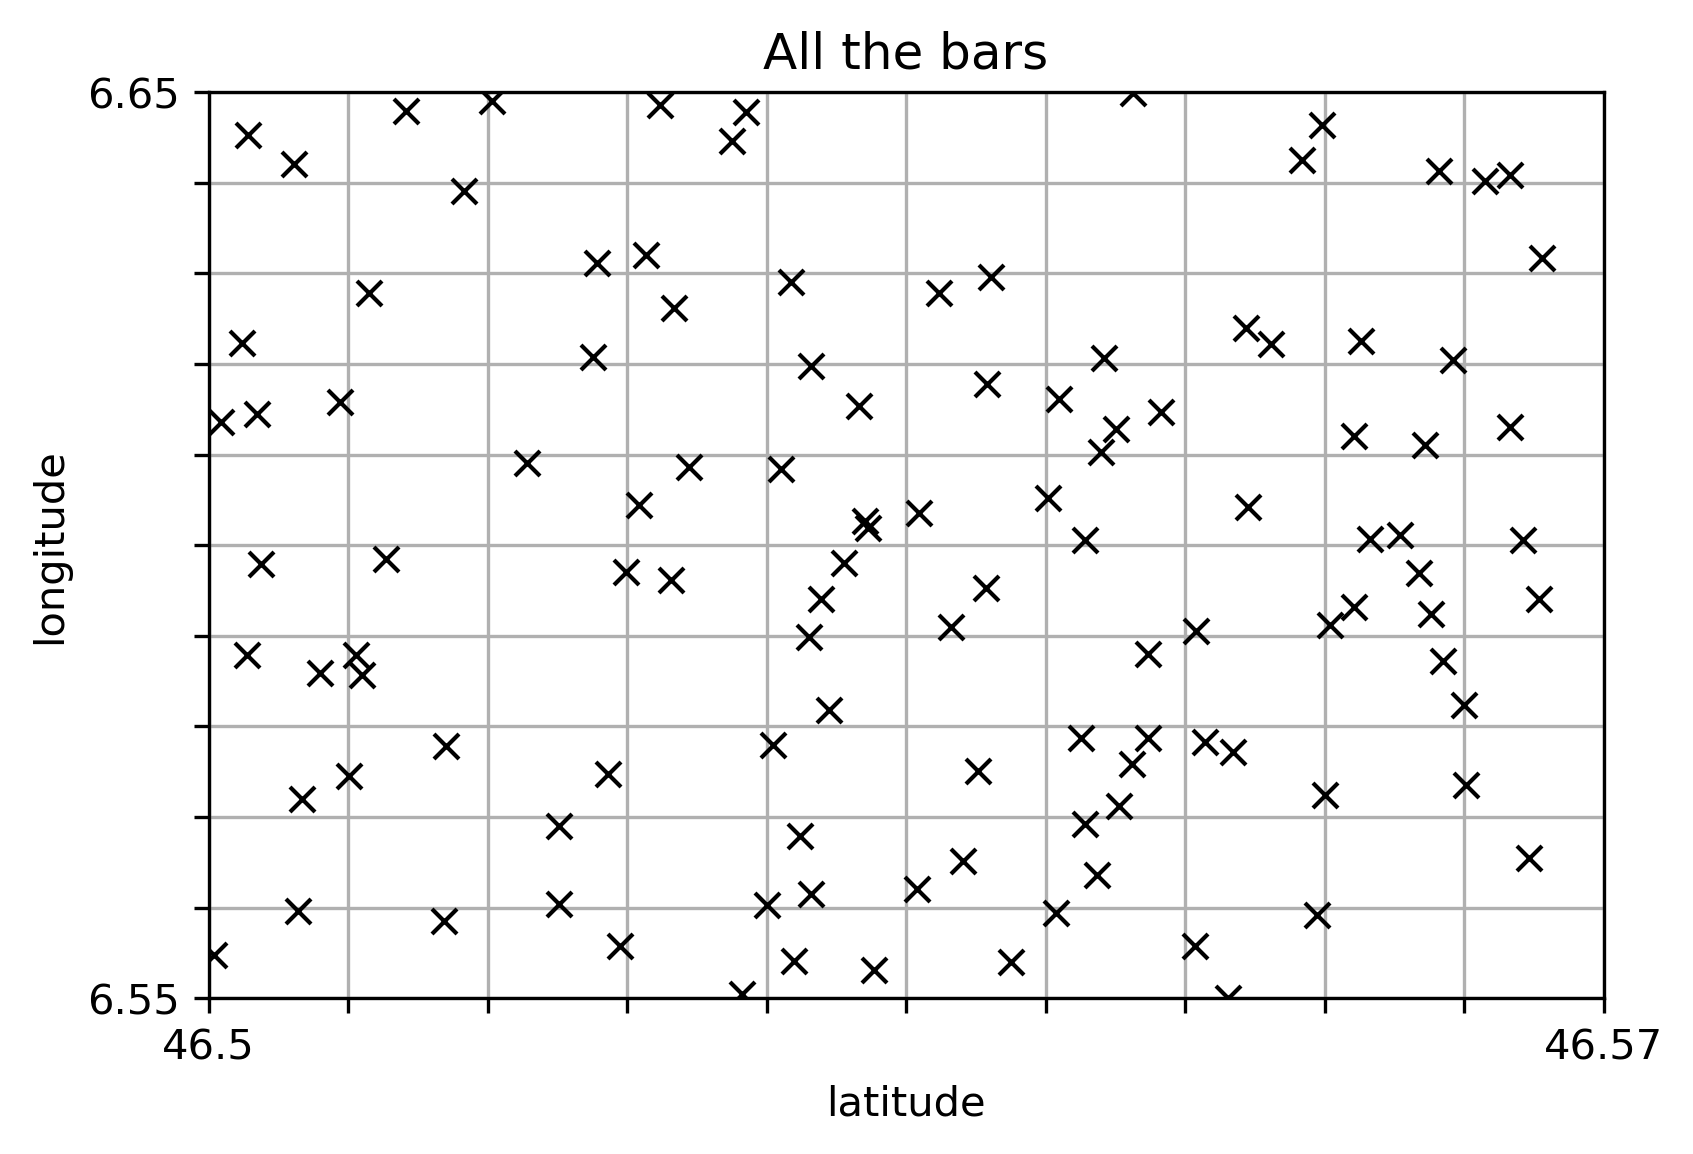

In [6]:
fig = draw_map()
for p in POIS["bar"]:
    plt.plot(p[2], p[3], "kx")
plt.title("All the bars")
plt.show()

# Breach privacy

In [7]:
HOME_TYPES = ["appartment_block", "villa"]
WORK_TYPES = ["office", "laboratory", "company"]
MEAL_TYPES = ["restaurant", "cafeteria"]
QUIET_TYPES = ["gym", "dojo"]
ANIMATED_TYPES = ["bar", "club"]

In [8]:
def match_location_poi(types):
    LOCATIONS = {}
    for t in types:
        LOCATIONS[t] = POIS[t]

    LOCATIONS_USES_TEMP = {}
    for ip_address in list(QUERIES.keys()):
        LOCATIONS_USES_TEMP[ip_address] = []
        for q_lat, q_lon, _, _ in QUERIES[ip_address]:
            for l in list(LOCATIONS.values()):
                for poi_id, cell_id, h_lat, h_lon in l:
                    if h_lat == q_lat and h_lon == q_lon:
                        LOCATIONS_USES_TEMP[ip_address].append((poi_id, cell_id, h_lat, h_lon))

    LOCATIONS_USES = {}
    for k, v in LOCATIONS_USES_TEMP.items():
        LOCATIONS_USES[k] = {poi:v.count(poi) for poi in v}
    
    return LOCATIONS_USES

In [9]:
def check_one_location(matched_locations):
    for k in list(matched_locations.keys()):
        if len(list(matched_locations[k])) != 1:
            return False
    return True

## Do people use the app at home ?

In [10]:
home_poi = match_location_poi(HOME_TYPES)
check_one_location(home_poi)

True

## Do people use the app at work ?

In [11]:
work_poi = match_location_poi(WORK_TYPES)
check_one_location(work_poi)

True

## Do people share home and work locations ?

In [12]:
ip_to_home_work = {}

for u in list(QUERIES.keys()):
    h = list(home_poi[u].keys())[0]
    w = list(work_poi[u].keys())[0]
    ip_to_home_work[u] = (h,w)

In [13]:
def plot_pairs():
    share_none = 0
    share_one  = 0
    share_both = 0

    users = list(QUERIES.keys())

    for i in range(len(users)):
        for j in range(i+1, len(users)):
            u, v = users[i], users[j]
            if ip_to_home_work[u] == ip_to_home_work[v]:
                share_both += 1
            elif ip_to_home_work[u][0] == ip_to_home_work[v][0] or ip_to_home_work[u][1] == ip_to_home_work[v][1]:
                share_one += 1
            else:
                share_none += 1
                
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_yscale('log')
    ax.bar(['share work and home', 'share work xor home', 'share none'], [share_both, share_one, share_none])
    plt.show()

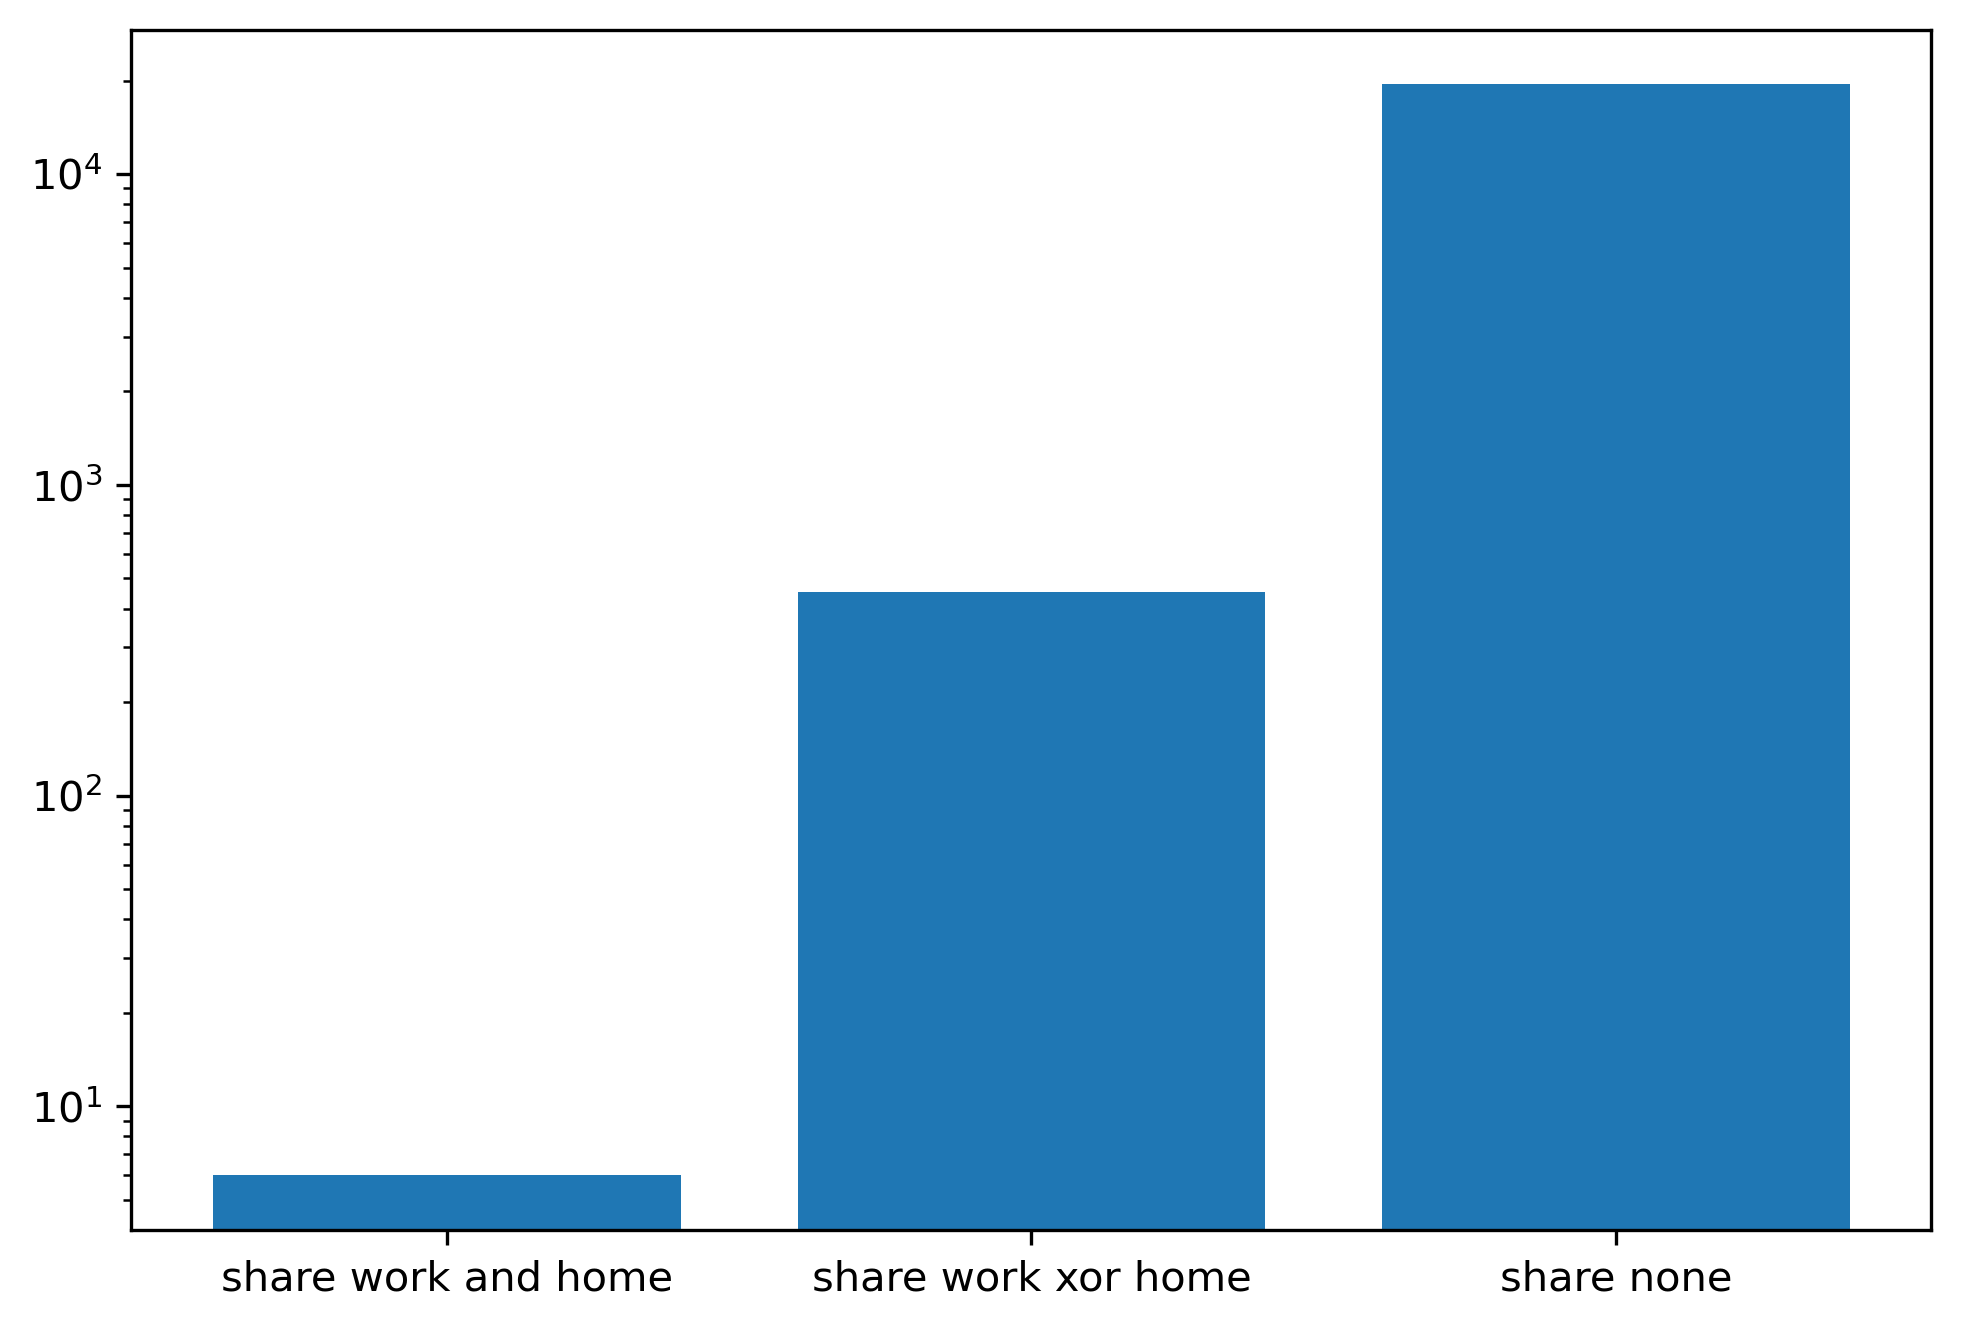

In [14]:
plot_pairs()

## When do people use the app ?

In [15]:
home_queries_time = []
work_queries_time = []

for ip, qs in QUERIES.items():
    temp_home_queries_time = []
    temp_work_queries_time = []
    for q in qs:
        lat, lon, tim, _ = q
        if (lat,lon) == ip_to_home_work[ip][0][-2:] and tim not in temp_home_queries_time:
            temp_home_queries_time.append(tim)
        elif (lat,lon) == ip_to_home_work[ip][1][-2:] and tim not in temp_work_queries_time:
            temp_work_queries_time.append(tim)
    
    home_queries_time += temp_home_queries_time
    work_queries_time += temp_work_queries_time

In [16]:
home_queries_hours_week = [int(t%24) for t in home_queries_time if int(t%168 // 24) <= 4]
work_queries_hours_week = [int(t%24) for t in work_queries_time if int(t%168 // 24) <= 4]

home_queries_hours_end = [int(t%24) for t in home_queries_time if int(t%168 // 24) > 4]
work_queries_hours_end = [int(t%24) for t in work_queries_time if int(t%168 // 24) > 4]

In [17]:
home_queries_hours_week_count = {}
work_queries_hours_week_count = {}
home_queries_hours_end_count = {}
work_queries_hours_end_count = {}

for i in range(24):
    home_queries_hours_week_count[i] = 0
    work_queries_hours_week_count[i] = 0
    home_queries_hours_end_count[i] = 0
    work_queries_hours_end_count[i] = 0
    
for h in home_queries_hours_week:
    home_queries_hours_week_count[h] += 1

for h in work_queries_hours_week:
    work_queries_hours_week_count[h] += 1
    
for h in home_queries_hours_end:
    home_queries_hours_end_count[h] += 1
    
for h in work_queries_hours_end:
    work_queries_hours_end_count[h] += 1

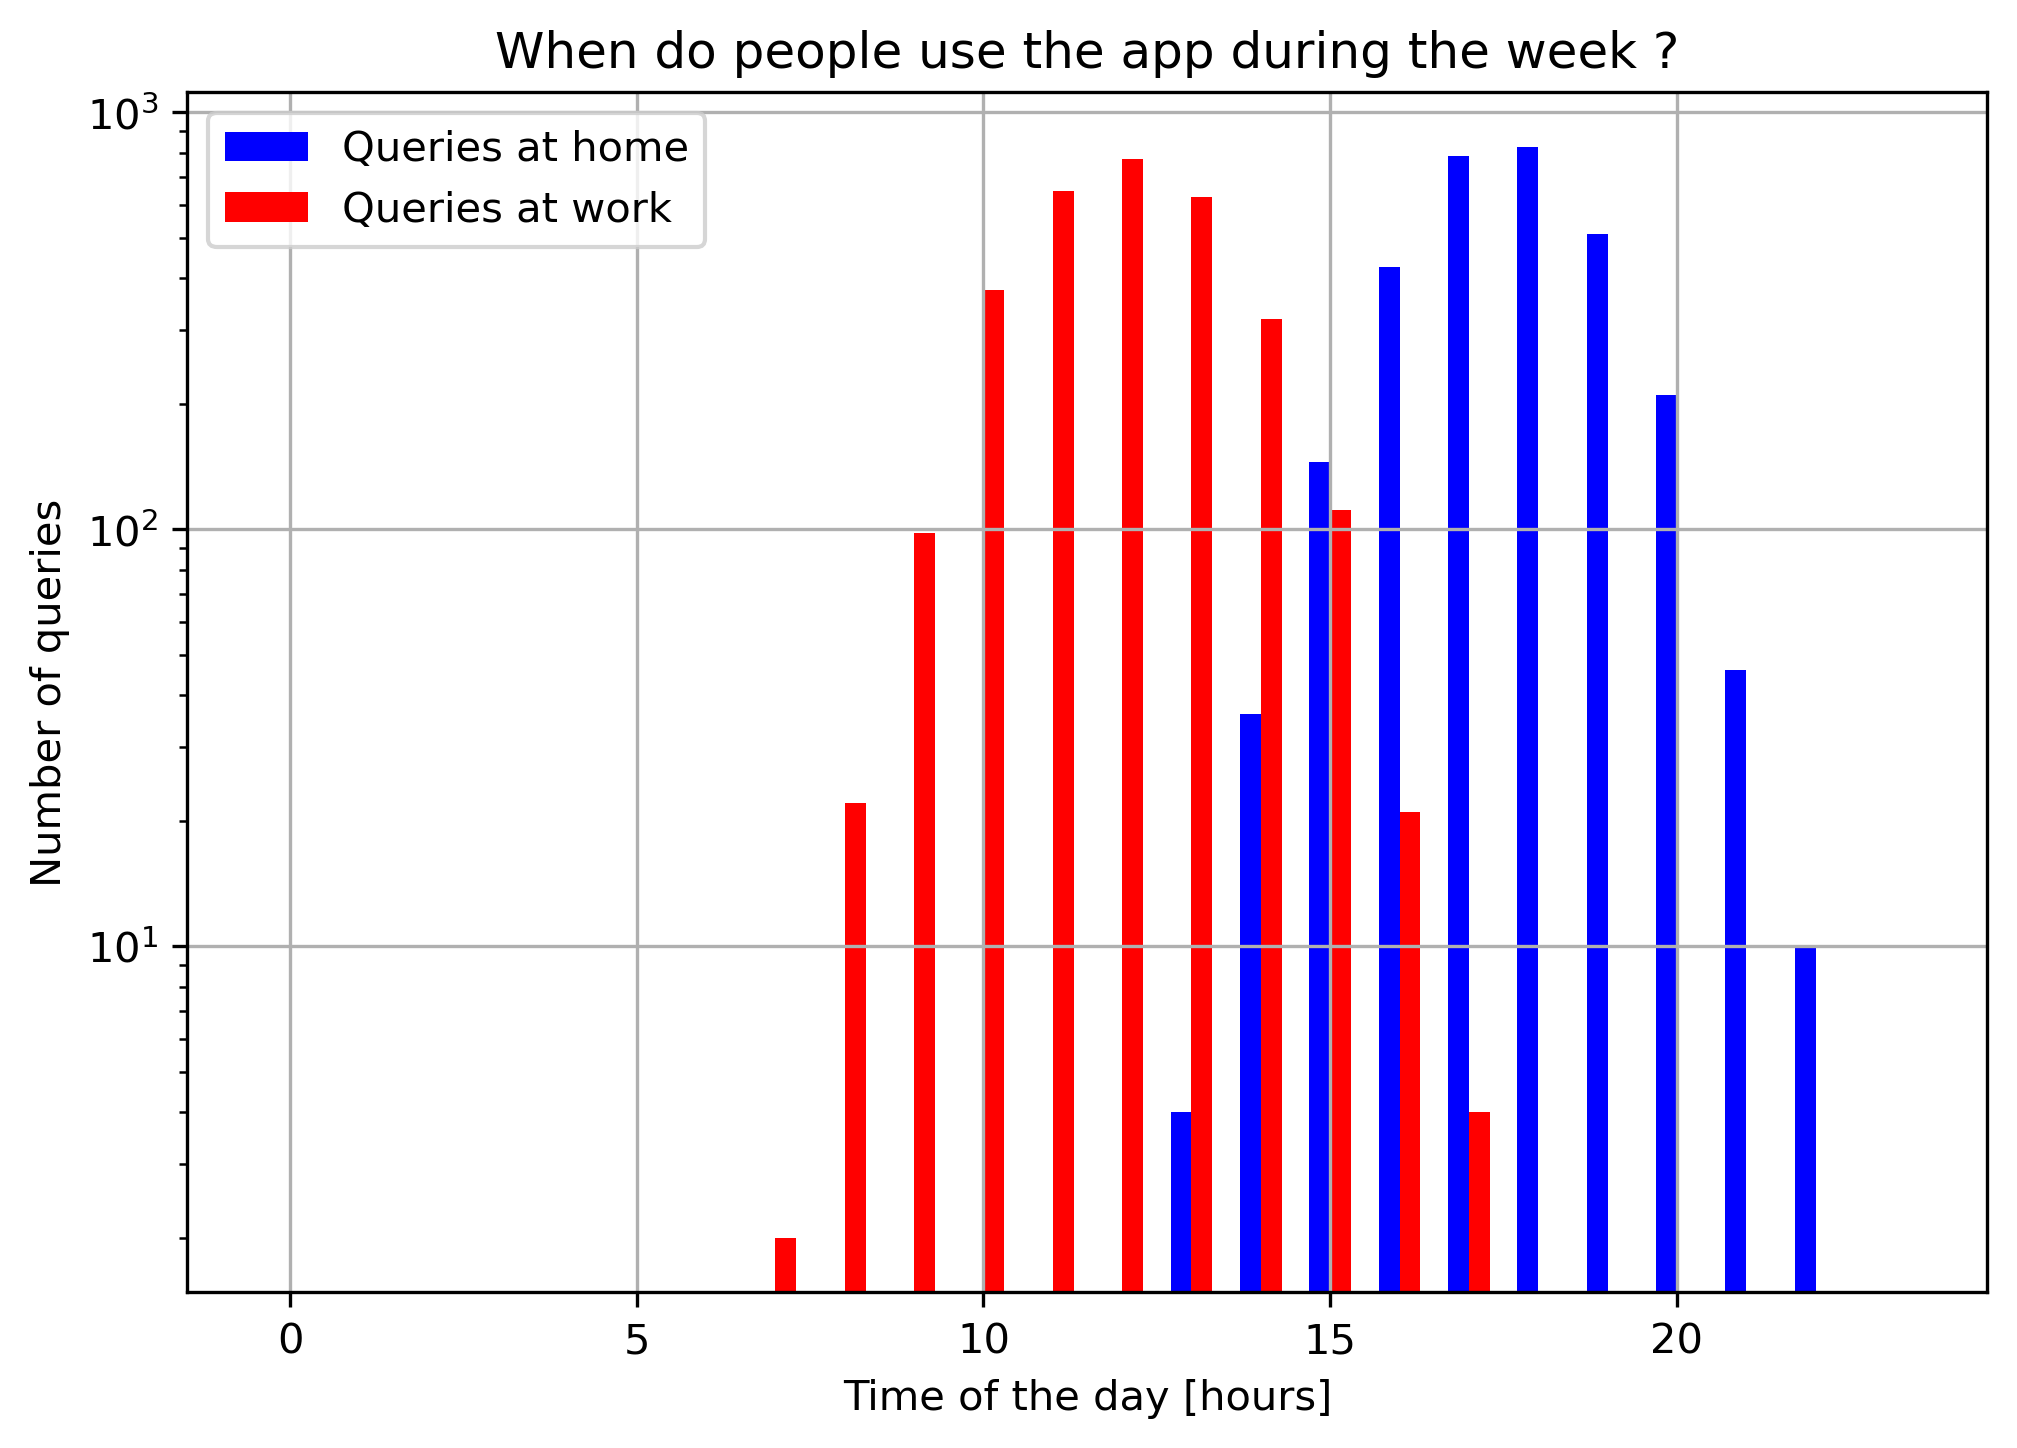

In [18]:
x = np.arange(24)

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.set_yscale('log')
ax.bar(x - 0.15, home_queries_hours_week_count.values(), color = 'b', width = 0.3, label="Queries at home")
ax.bar(x + 0.15, work_queries_hours_week_count.values(), color = 'r', width = 0.3, label="Queries at work")
ax.legend()

plt.title("When do people use the app during the week ?")
plt.xlabel("Time of the day [hours]")
plt.ylabel("Number of queries")
plt.grid()
plt.savefig("when.png", dpi=300, bbox_inches='tight')
plt.show()

In [19]:
home_queries_days = [int(t%168 // 24) for t in home_queries_time]
work_queries_days = [int(t%168 // 24) for t in work_queries_time]

In [20]:
home_queries_days_count = {}
work_queries_days_count = {}

for i in range(7):
    home_queries_days_count[i] = 0
    work_queries_days_count[i] = 0
    
for d in home_queries_days:
    home_queries_days_count[d] += 1
    
for d in work_queries_days:
    work_queries_days_count[d] += 1

In [21]:
home_queries_days_count

{0: 600, 1: 600, 2: 600, 3: 600, 4: 600, 5: 600, 6: 400}

In [22]:
work_queries_days_count

{0: 600, 1: 600, 2: 600, 3: 600, 4: 600, 5: 0, 6: 0}

# What if we follow a random user ?

In [23]:
RANDOM_USER_IP = "203.24.85.254"
RANDOM_USER_QUERIES = QUERIES[RANDOM_USER_IP]
RANDOM_USER_HOME_LOC, RANDOM_USER_WORK_LOC = ip_to_home_work[RANDOM_USER_IP]

## Where does the user live ?

In [24]:
RANDOM_USER_HOME_LOC

(155, 85, 46.558367810027065, 6.599673120084034)

## Where does the user work ?

In [25]:
RANDOM_USER_WORK_LOC

(245, 53, 46.53591906517015, 6.575487739371415)

In [26]:
match_location_poi(MEAL_TYPES)[RANDOM_USER_IP]

{(788, 85, 46.55998101235366, 6.598492025794768): 8,
 (797, 85, 46.5581068683577, 6.598927912376763): 8,
 (428, 20, 46.51079863007427, 6.6432881558265775): 1,
 (586, 63, 46.54851857096879, 6.574898808785238): 1,
 (638, 79, 46.55413479527682, 6.633872543413956): 1,
 (953, 94, 46.56422486816315, 6.585129756341301): 1,
 (879, 72, 46.554278117280205, 6.568650536894085): 1}

## Which meals does the user prefer ?

In [27]:
RANDOM_USER_MEAL = [(46.55998101235366, 6.598492025794768),
                    (46.5581068683577, 6.598927912376763)]

## Which activities does the user prefer ?

In [28]:
match_location_poi(QUIET_TYPES)[RANDOM_USER_IP]

{(975, 91, 46.56403808949643, 6.5531573956034626): 1,
 (800, 20, 46.509750738150636, 6.641607048994993): 1,
 (366, 49, 46.53451294641933, 6.639985826523506): 1}

In [29]:
match_location_poi(ANIMATED_TYPES)[RANDOM_USER_IP]

{(305, 85, 46.55626358771141, 6.591222669318815): 6,
 (819, 20, 46.50989513470177, 6.647912914642325): 1,
 (926, 85, 46.5613247900066, 6.59239490482244): 2,
 (436, 85, 46.557453635243554, 6.593135121452934): 2,
 (547, 63, 46.54715418583834, 6.57867323088001): 1}

In [30]:
RANDOM_USER_ACTIVITIES = [(46.55626358771141, 6.591222669318815)]

In [31]:
## What does the user do on the weekend ?

In [32]:
RANDOM_USER_NO_HOME_NOR_WORK = [q for q in RANDOM_USER_QUERIES if (q[0] != RANDOM_USER_HOME_LOC[2] and
                                                                   q[1] != RANDOM_USER_HOME_LOC[3]) and
                                                                  (q[0] != RANDOM_USER_WORK_LOC[2] and
                                                                   q[1] != RANDOM_USER_WORK_LOC[3])]

RANDOM_USER_WEEKEND = []

for q in RANDOM_USER_NO_HOME_NOR_WORK:
    d = int((q[2]/24)%7)
    if 5 <= d:
        RANDOM_USER_WEEKEND.append(q)
        
RANDOM_USER_WEEKEND_POIS = []

for k,v in POIS.items():
    for p in v:
        for w in RANDOM_USER_WEEKEND:
            if p[2] == w[0] and p[3] == w[1]:
                RANDOM_USER_WEEKEND_POIS.append((w,k))
                
RANDOM_USER_WEEKEND_POIS

[((46.50989513470177, 6.647912914642325, 153.96376068497736, 'restaurant'),
  'bar'),
 ((46.54715418583834, 6.57867323088001, 297.14481526452664, 'restaurant'),
  'bar'),
 ((46.51079863007427, 6.6432881558265775, 153.96376068497736, 'cafeteria'),
  'restaurant'),
 ((46.54851857096879, 6.574898808785238, 297.14481526452664, 'cafeteria'),
  'restaurant'),
 ((46.55413479527682, 6.633872543413956, 320.5864478213704, 'cafeteria'),
  'restaurant'),
 ((46.56422486816315, 6.585129756341301, 464.4383847951128, 'cafeteria'),
  'restaurant'),
 ((46.554278117280205, 6.568650536894085, 464.4383847951128, 'gym'),
  'cafeteria'),
 ((46.509750738150636, 6.641607048994993, 153.96376068497736, 'bar'), 'gym'),
 ((46.53451294641933, 6.639985826523506, 297.14481526452664, 'bar'), 'gym'),
 ((46.56403808949643, 6.5531573956034626, 128.74665775824968, 'bar'), 'gym')]

In [33]:
RANDOM_USER_WEEKEND_GYM = [(46.509750738150636, 6.641607048994993, 153.96376068497736),
                           (46.53451294641933, 6.639985826523506, 297.14481526452664),
                           (46.56403808949643, 6.5531573956034626, 128.74665775824968)]

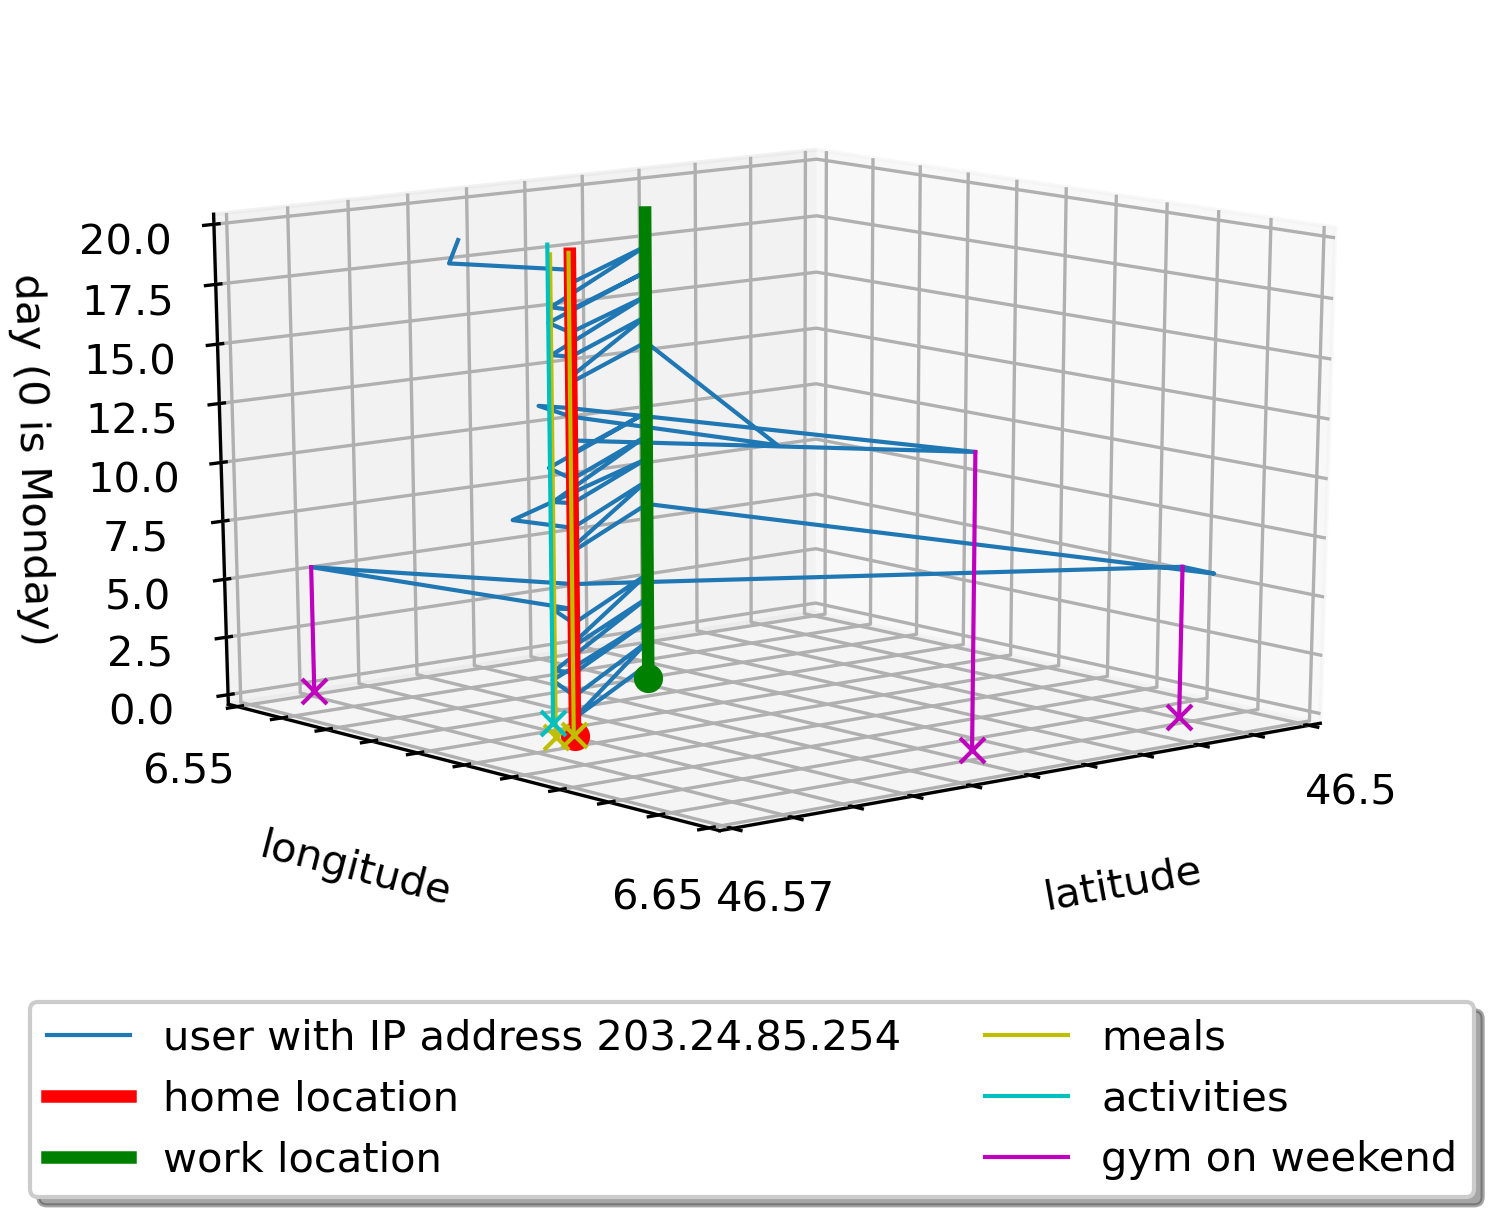

In [34]:
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(MAP_LAT, MAP_LAT+MAP_SIZE_LAT, CELL_NUM_LAT+1)
y = np.linspace(MAP_LON, MAP_LON+MAP_SIZE_LON, CELL_NUM_LON+1)

RANDOM_USER_LAT = [t[0] for t in RANDOM_USER_QUERIES]
RANDOM_USER_LON = [t[1] for t in RANDOM_USER_QUERIES]
RANDOM_USER_TIM = [t[2] for t in RANDOM_USER_QUERIES]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.axis([MAP_LAT, MAP_LAT+MAP_SIZE_LAT, MAP_LON, MAP_LON+MAP_SIZE_LON])
plt.xticks(x)
plt.yticks(y)

ax.plot(RANDOM_USER_LAT, RANDOM_USER_LON, [t/24 for t in RANDOM_USER_TIM], label="user with IP address {}".format(RANDOM_USER_IP), linewidth=1)
ax.plot([RANDOM_USER_HOME_LOC[2]], [RANDOM_USER_HOME_LOC[3]], 0, "ro")
ax.plot([RANDOM_USER_HOME_LOC[2]]*2,[RANDOM_USER_HOME_LOC[3]]*2, [0,20], "r", label="home location", linewidth=3)
ax.plot([RANDOM_USER_WORK_LOC[2]], [RANDOM_USER_WORK_LOC[3]], 0, "go")
ax.plot([RANDOM_USER_WORK_LOC[2]]*2,[RANDOM_USER_WORK_LOC[3]]*2, [0,20], "g", label="work location", linewidth=3)

for m,i in zip(RANDOM_USER_MEAL, range(len(RANDOM_USER_MEAL))):
    ax.plot([m[0]], [m[1]], 0, "yx")
    ax.plot([m[0]]*2, [m[1]]*2, [0,20], "y", label="meals" if i == 0 else "", linewidth=1)
    
for a,i in zip(RANDOM_USER_ACTIVITIES, range(len(RANDOM_USER_ACTIVITIES))):
    ax.plot([a[0]], [a[1]], 0, "cx")
    ax.plot([a[0]]*2, [a[1]]*2, [0,20], "c", label="activities" if i == 0 else "", linewidth=1)
    
for g,i in zip(RANDOM_USER_WEEKEND_GYM, range(len(RANDOM_USER_WEEKEND_GYM))):
    ax.plot([g[0]], [g[1]], 0, "mx")
    ax.plot([g[0]]*2, [g[1]]*2, [0,g[2]/24], "m", label="gym on weekend" if i == 0 else "", linewidth=1)


x_labels = ax.get_xticks().tolist()
x_labels_new = [round(x_labels[i],2) if (i == 0 or i == CELL_NUM_LAT) else "" for i in range(len(x_labels))]
ax.set_xticklabels(x_labels_new)

y_labels = ax.get_yticks().tolist()
y_labels_new = [round(y_labels[i],2) if (i == 0 or i == CELL_NUM_LON) else "" for i in range(len(y_labels))]
ax.set_yticklabels(y_labels_new)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)

ax.set_xlabel("latitude")
ax.set_ylabel('longitude')
ax.set_zlabel('day (0 is Monday)')

ax.view_init(15, 50)

plt.show()